# 01 — Screen & Build Combined Universe

Uses `yfscreen` to systematically construct investable universes across multiple sectors,
then combines them into a single universe for cross-sector clustering.

**Pipeline:**
1. Explore available yfscreen filter fields
2. Define screening criteria (liquidity, fundamentals)
3. Run screen for each target sector
4. Combine all sectors into one universe with sector map
5. Fetch prices and apply data quality filters
6. Cache combined universe to `screener/data/combined/`

In [1]:
import sys, os

# Project root must come FIRST on sys.path so that 'config' resolves
# to the project-level config.py, not screener/config.py.
project_root = os.path.abspath(os.path.join('..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfscreen as yfs

from screener.config import ScreenerConfig
from screener.screening import (
    explore_available_filters, screen_combined_universe,
)
from screener.universe import fetch_and_validate_prices, cache_universe

%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## 1. Explore Available yfscreen Filters

Confirm the exact field names for market cap, volume, EBITDA, etc.

In [2]:
filters = explore_available_filters()

Available equity filters (96):
  Region                                         field=region                                    type=str
  Symbol                                         field=ticker                                    type=str
  Price (Intraday)                               field=intradayprice                             type=float
  Price (End of Day)                             field=eodprice                                  type=float
  Volume                                         field=dayvolume                                 type=float
  Volume (End of Day)                            field=eodvolume                                 type=float
  Avg Vol (3 month)                              field=avgdailyvol3m                             type=float
  Market Cap (Intraday)                          field=intradaymarketcap                         type=float
  Sector                                         field=sector                                    type=str
  I

## 2. Configure Screening Parameters

In [3]:
cfg = ScreenerConfig()
print("Screening config:")
for field in cfg.__dataclass_fields__:
    print(f"  {field}: {getattr(cfg, field)}")

Screening config:
  region: us
  min_market_cap: 2000000000
  min_daily_volume: 5000000
  min_price: 5.0
  require_positive_ebitda: True
  max_universe_size: 80
  min_universe_size: 15
  min_data_coverage: 0.8
  data_period: 252d
  data_interval: 1h
  sectors: ('Technology', 'Healthcare', 'Energy', 'Financial Services', 'Industrials')


## 3. Screen All Sectors & Build Combined Universe

In [4]:
combined_tickers, sector_map, per_sector = screen_combined_universe(cfg)

print(f"\nTotal tickers (incl ^GSPC): {len(combined_tickers)}")
print(f"Sector map entries: {len(sector_map)}")

# Show sector composition
sector_counts = pd.Series(sector_map).value_counts()
print("\nSector composition:")
for sector, count in sector_counts.items():
    print(f"  {sector}: {count}")


Screening Technology...


  Technology: 59 stocks selected

Screening Healthcare...


  Healthcare: 24 stocks selected

Screening Energy...


  Energy: 27 stocks selected

Screening Financial Services...


  Financial Services: 15 stocks selected

Screening Industrials...


  Industrials: 18 stocks selected

Combined universe: 143 stocks from 5 sectors
  Technology: 59
  Healthcare: 24
  Energy: 27
  Financial Services: 15
  Industrials: 18

Total tickers (incl ^GSPC): 144
Sector map entries: 143

Sector composition:
  Technology: 59
  Energy: 27
  Healthcare: 24
  Industrials: 18
  Financial Services: 15


## 4. Fetch Prices & Apply Data Quality Filters

In [5]:
print(f"Fetching prices for {len(combined_tickers)} tickers...")
prices, dropped = fetch_and_validate_prices(combined_tickers, cfg)

kept_tickers = [c for c in prices.columns if c != '^GSPC']
print(f"\nKept: {len(kept_tickers)} tickers")
print(f"Dropped: {len(dropped)} tickers")

if dropped:
    for ticker, reason in dropped[:10]:
        print(f"  {ticker}: {reason}")
    if len(dropped) > 10:
        print(f"  ... and {len(dropped) - 10} more")

# Update sector_map to only include kept tickers
sector_map = {t: s for t, s in sector_map.items() if t in kept_tickers}
print(f"\nSector map after filtering: {len(sector_map)} tickers")

sector_counts = pd.Series(sector_map).value_counts()
for sector, count in sector_counts.items():
    print(f"  {sector}: {count}")

Fetching prices for 144 tickers...


[                       0%                       ]

[                       1%                       ]  2 of 144 completed

[*                      3%                       ]  5 of 144 completed

[**                     4%                       ]  6 of 144 completed

[**                     5%                       ]  7 of 144 completed

[***                    6%                       ]  8 of 144 completed

[***                    6%                       ]  9 of 144 completed

[***                    7%                       ]  10 of 144 completed

[****                   8%                       ]  11 of 144 completed

[****                   8%                       ]  12 of 144 completed

[****                   9%                       ]  13 of 144 completed

[*****                 10%                       ]  14 of 144 completed

[*****                 10%                       ]  15 of 144 completed

[*****                 11%                       ]  16 of 144 completed

[******                12%                       ]  17 of 144 completed

[******                12%                       ]  18 of 144 completed

[******                13%                       ]  19 of 144 completed

[*******               14%                       ]  20 of 144 completed

[*******               15%                       ]  21 of 144 completed

[*******               15%                       ]  22 of 144 completed

[********              16%                       ]  23 of 144 completed

[********              17%                       ]  24 of 144 completed

[********              17%                       ]  25 of 144 completed

[*********             18%                       ]  26 of 144 completed

[*********             19%                       ]  27 of 144 completed

[*********             19%                       ]  28 of 144 completed

[**********            20%                       ]  29 of 144 completed

[**********            21%                       ]  30 of 144 completed

[***********           22%                       ]  31 of 144 completed

[***********           22%                       ]  32 of 144 completed

[***********           23%                       ]  33 of 144 completed

[************          24%                       ]  34 of 144 completed

[************          25%                       ]  36 of 144 completed

[************          26%                       ]  37 of 144 completed

[************          26%                       ]  38 of 144 completed

[*************         27%                       ]  39 of 144 completed

[*************         28%                       ]  40 of 144 completed

[*************         28%                       ]  41 of 144 completed

[**************        29%                       ]  42 of 144 completed

[**************        30%                       ]  43 of 144 completed

[***************       31%                       ]  44 of 144 completed

[***************       31%                       ]  45 of 144 completed

[***************       32%                       ]  46 of 144 completed

[****************      33%                       ]  47 of 144 completed

[****************      33%                       ]  48 of 144 completed

[****************      34%                       ]  49 of 144 completed

[*****************     35%                       ]  50 of 144 completed

[*****************     35%                       ]  51 of 144 completed

[*****************     35%                       ]  51 of 144 completed

[******************    37%                       ]  53 of 144 completed

[******************    38%                       ]  54 of 144 completed

[******************    38%                       ]  55 of 144 completed

[*******************   39%                       ]  56 of 144 completed

[*******************   39%                       ]  56 of 144 completed

[*******************   40%                       ]  58 of 144 completed

[********************  42%                       ]  60 of 144 completed

[********************  42%                       ]  60 of 144 completed

[********************* 43%                       ]  62 of 144 completed

[********************* 44%                       ]  63 of 144 completed

[********************* 44%                       ]  64 of 144 completed

[********************* 44%                       ]  64 of 144 completed

[**********************47%                       ]  67 of 144 completed

[**********************48%                       ]  69 of 144 completed

[**********************49%                       ]  70 of 144 completed

[**********************49%                       ]  71 of 144 completed

[**********************51%                       ]  73 of 144 completed

[**********************51%                       ]  74 of 144 completed

[**********************52%                       ]  75 of 144 completed

[**********************53%                       ]  76 of 144 completed

[**********************53%                       ]  77 of 144 completed

[**********************54%*                      ]  78 of 144 completed

[**********************55%*                      ]  79 of 144 completed

[**********************56%**                     ]  80 of 144 completed

[**********************56%**                     ]  81 of 144 completed

[**********************56%**                     ]  81 of 144 completed

[**********************58%***                    ]  83 of 144 completed

[**********************59%***                    ]  85 of 144 completed

[**********************60%****                   ]  86 of 144 completed

[**********************60%****                   ]  87 of 144 completed

[**********************61%****                   ]  88 of 144 completed

[**********************62%*****                  ]  89 of 144 completed

[**********************62%*****                  ]  90 of 144 completed

[**********************63%*****                  ]  91 of 144 completed

[**********************64%******                 ]  92 of 144 completed

[**********************65%******                 ]  93 of 144 completed

[**********************65%******                 ]  93 of 144 completed

[**********************66%*******                ]  95 of 144 completed

[**********************67%*******                ]  96 of 144 completed

[**********************67%*******                ]  97 of 144 completed

[**********************68%********               ]  98 of 144 completed

[**********************69%********               ]  99 of 144 completed

[**********************69%********               ]  100 of 144 completed

[**********************70%*********              ]  101 of 144 completed

[**********************72%**********             ]  103 of 144 completed

[**********************72%**********             ]  104 of 144 completed

[**********************73%**********             ]  105 of 144 completed

[**********************73%**********             ]  105 of 144 completed

[**********************74%***********            ]  107 of 144 completed

[**********************75%***********            ]  108 of 144 completed

[**********************76%***********            ]  109 of 144 completed

[**********************76%***********            ]  110 of 144 completed

[**********************77%************           ]  111 of 144 completed

[**********************78%************           ]  112 of 144 completed

[**********************78%************           ]  113 of 144 completed

[**********************79%*************          ]  114 of 144 completed

[**********************80%*************          ]  115 of 144 completed

[**********************81%**************         ]  116 of 144 completed

[**********************81%**************         ]  117 of 144 completed

[**********************83%***************        ]  119 of 144 completed

[**********************83%***************        ]  120 of 144 completed

[**********************84%***************        ]  121 of 144 completed

[**********************85%****************       ]  122 of 144 completed

[**********************85%****************       ]  123 of 144 completed

[**********************86%****************       ]  124 of 144 completed

[**********************87%*****************      ]  125 of 144 completed

[**********************88%*****************      ]  126 of 144 completed

[**********************88%*****************      ]  127 of 144 completed

[**********************89%******************     ]  128 of 144 completed

[**********************90%******************     ]  129 of 144 completed

[**********************90%******************     ]  130 of 144 completed

[**********************91%*******************    ]  131 of 144 completed

[**********************92%*******************    ]  133 of 144 completed

[**********************92%*******************    ]  133 of 144 completed

[**********************94%********************   ]  135 of 144 completed

[**********************94%********************   ]  136 of 144 completed

[**********************95%*********************  ]  137 of 144 completed

[**********************96%*********************  ]  138 of 144 completed

[**********************96%*********************  ]  138 of 144 completed

[**********************97%********************** ]  140 of 144 completed

[**********************98%********************** ]  141 of 144 completed

[**********************99%***********************]  142 of 144 completed

[**********************99%***********************]  143 of 144 completed

[*********************100%***********************]  144 of 144 completed


Kept: 142 tickers
Dropped: 1 tickers
  MDLN: low coverage (17.4%)

Sector map after filtering: 142 tickers
  Technology: 59
  Energy: 27
  Healthcare: 23
  Industrials: 18
  Financial Services: 15


## 5. Data Quality Report

In [6]:
coverage = prices[kept_tickers].notna().mean()

print(f"Price matrix: {prices.shape[0]} timestamps x {len(kept_tickers)} tickers")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")
print(f"Avg coverage: {coverage.mean():.1%}")
print(f"Min coverage: {coverage.min():.1%}")
print(f"Median coverage: {coverage.median():.1%}")

# Per-sector quality
for sector in sorted(set(sector_map.values())):
    stickers = [t for t, s in sector_map.items() if s == sector]
    scov = prices[stickers].notna().mean()
    print(f"\n  {sector} ({len(stickers)} tickers):")
    print(f"    Avg coverage: {scov.mean():.1%}, Min: {scov.min():.1%}")

Price matrix: 1744 timestamps x 142 tickers
Date range: 2025-02-21 14:30:00+00:00 to 2026-02-23 20:30:00+00:00
Avg coverage: 99.9%
Min coverage: 89.8%
Median coverage: 100.0%

  Energy (27 tickers):
    Avg coverage: 100.0%, Min: 100.0%

  Financial Services (15 tickers):
    Avg coverage: 100.0%, Min: 100.0%

  Healthcare (23 tickers):
    Avg coverage: 100.0%, Min: 100.0%

  Industrials (18 tickers):
    Avg coverage: 100.0%, Min: 100.0%

  Technology (59 tickers):
    Avg coverage: 99.8%, Min: 89.8%


## 6. Cache Combined Universe

In [7]:
# Cache with sector_map so downstream notebooks can classify pairs
cache_universe('combined', kept_tickers + ['^GSPC'], prices, sector_map=sector_map)
print("Combined universe cached to screener/data/combined/")

  Cached combined: 143 tickers, prices shape (1744, 143)
Combined universe cached to screener/data/combined/


## 7. Universe Composition Visualization

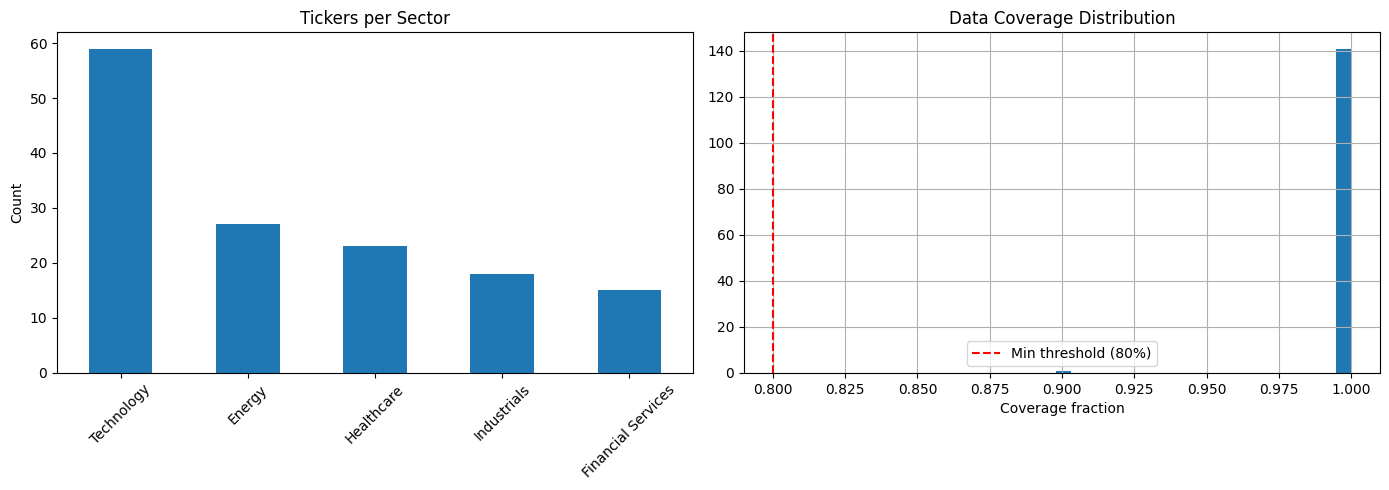

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sector distribution
sector_counts = pd.Series(sector_map).value_counts()
sector_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Tickers per Sector')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Coverage distribution
coverage.hist(bins=20, ax=axes[1])
axes[1].axvline(x=cfg.min_data_coverage, color='r', linestyle='--', label=f'Min threshold ({cfg.min_data_coverage:.0%})')
axes[1].set_title('Data Coverage Distribution')
axes[1].set_xlabel('Coverage fraction')
axes[1].legend()

plt.tight_layout()
plt.show()